# Personal Extensions to Spotify Popularity Analysis

This notebook contains my personal extensions and improvements to the original group project completed for UCLA CS M148.  
Original group project notebook: `01_Group_Baseline_Popularity_Analysis.ipynb`.

#Data Loading

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import plotly.express as px
import shap

In [3]:
spotify_data = pd.read_csv('dataset.csv', index_col = 0)
pd.set_option('display.max_columns', None)
spotify_data.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
spotify_data['popularity'] = (spotify_data['popularity'] > 70).astype(int)
spotify_data.shape

(114000, 20)

In [5]:
feature_cols = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

X = spotify_data[feature_cols]
y = spotify_data['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Applying SMOTE

In [6]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## New Random Forest

In [7]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_rf_pred = rf.predict(X_test)

pred_val_rf = pd.DataFrame({
    'true': y_test,
    'rf_predict': y_rf_pred
})

pred_val_rf.head()

,true,rf_predict
113186,0,0
42819,0,0
59311,0,0
91368,0,0
61000,0,0


[[21460   411]
 [  347   582]]


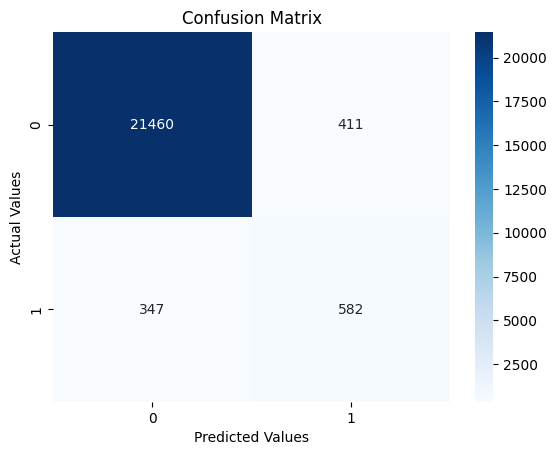

Accuracy: 0.9667543859649123
True Positive Rate: 0.6264800861141012
True Negative Rate: 0.9812079923185953


In [8]:
# Confusion Matrix
conf_rf = metrics.confusion_matrix(y_true=pred_val_rf['true'],
                                   y_pred=pred_val_rf['rf_predict'])
print(conf_rf)

sns.heatmap(conf_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

# Confusion Matrix Metrics
rf_accuracy = metrics.accuracy_score(y_true=pred_val_rf['true'],
                       y_pred=pred_val_rf['rf_predict'])

rf_truepositive = metrics.recall_score(y_true=pred_val_rf['true'],
                       y_pred=pred_val_rf['rf_predict'])

rf_truenegative = metrics.recall_score(y_true=pred_val_rf['true'],
                       y_pred=pred_val_rf['rf_predict'],
                                       pos_label=0)

print('Accuracy:', rf_accuracy)
print('True Positive Rate:', rf_truepositive)
print('True Negative Rate:', rf_truenegative)

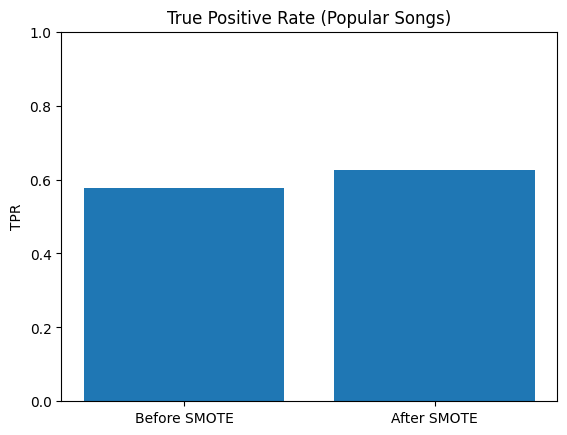

In [9]:
plt.bar(['Before SMOTE', 'After SMOTE'], [0.5779, 0.6265])
plt.title('True Positive Rate (Popular Songs)')
plt.ylabel('TPR')
plt.ylim(0, 1)
plt.show()

To address class imbalance, I applied SMOTE to upsample the minority class of “popular” songs. After training a Random Forest classifier on the resampled data, the true positive rate improved from 57.8% to 62.6%, suggesting better detection of popular songs. However, this came with a small tradeoff in overall accuracy (97.99% → 96.68%) and true negative rate. While the gain was modest, this demonstrates how resampling can help rebalance predictive performance across imbalanced classes.

In [10]:
# AUC
rf_auc_sample = metrics.roc_auc_score(pred_val_rf['true'], pred_val_rf['rf_predict'])
print('Random Forest AUC:', rf_auc_sample.round(3))

Random Forest AUC: 0.804


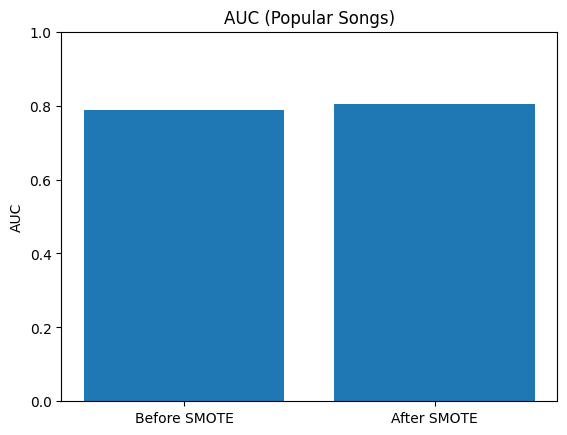

In [11]:
plt.bar(['Before SMOTE', 'After SMOTE'], [0.788, 0.804])
plt.title('AUC (Popular Songs)')
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.show()

After applying SMOTE to address class imbalance, the Random Forest model’s AUC improved from 0.788 to 0.804, indicating a stronger ability to distinguish between popular and unpopular songs. This aligns with the observed increase in true positive rate (from 57.8% to 62.6%), suggesting that resampling helped the model better identify minority class instances without significantly sacrificing accuracy.

In [12]:
y_rf_pred_proba = rf.predict_proba(X_test)[:, 1]

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_rf_pred_proba)

roc_rf_sample = pd.DataFrame({
    'False Positive Rate': rf_fpr,
    'True Positive Rate': rf_tpr,
    'Model': 'Random Forest'
}, index= rf_thresholds)

roc_rf_df = pd.concat([roc_rf_sample])

px.line(roc_rf_df, y='True Positive Rate', x='False Positive Rate',
        color='Model',
        width=800, height=500,
        title = "After SMOTE ROC"
)

While I explored ROC curves before and after applying SMOTE, the visual difference was minimal. However, the underlying metrics showed measurable improvement: the true positive rate increased from ~58% to ~63%, and the AUC rose slightly from 0.788 to 0.804. Given the imbalance in the dataset, even small gains in detecting popular songs are meaningful.

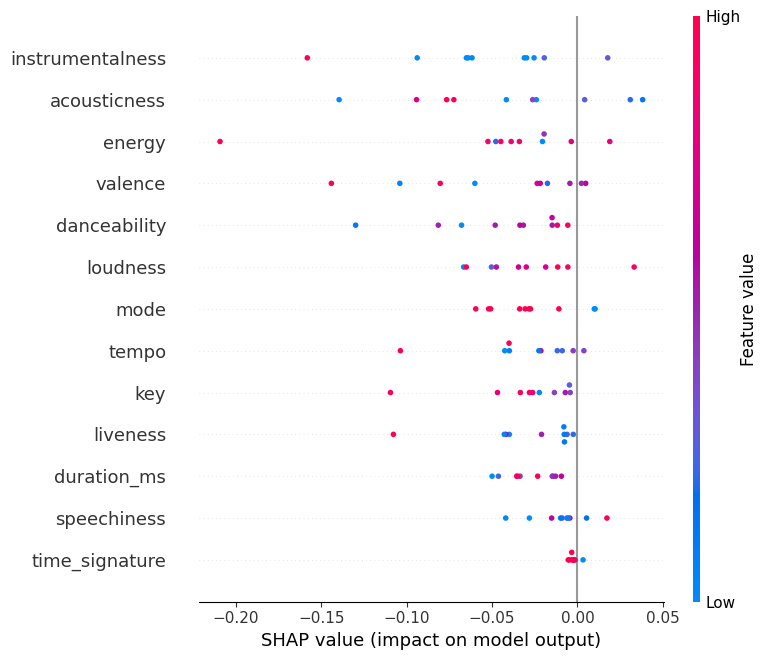

In [13]:
X_test_sampled = X_test.sample(n=10, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_sampled)

# Global summary plot for class 1 (popular)
shap.summary_plot(shap_values[:, :, 1], X_test_sampled)

Using SHAP values, I analyzed how each audio feature influenced the Random Forest model's predictions for song popularity. The plot reveals that features like instrumentalness, acousticness, and valence tend to negatively impact the likelihood of a song being popular. In contrast, higher energy slightly pushes predictions toward popularity. Other features like tempo, loudness, and danceability showed more subtle or mixed effects, suggesting their influence may depend on context or interactions with other features.

# Prep to Move Model Into App

In [14]:
import pickle

# save model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

In [15]:
# checking the size of the model
!ls -lh random_forest_model.pkl

-rw-r--r-- 1 root root 129M Jun 15 01:21 random_forest_model.pkl


In [16]:
# save X_train
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [17]:
from google.colab import files
files.download('random_forest_model.pkl')
files.download('X_train.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Further Exploration: trying to pick a few songs that I like  

In [18]:
popular_songs = spotify_data[spotify_data['popularity'] == 1]
popular_songs.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,1,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,1,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,1,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,1,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,1,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic


In [19]:
sorted = popular_songs.sort_values('popularity', ascending=False)[['track_name', 'artists', 'popularity']]

In [28]:
sorted.loc[::300]

,track_name,artists,popularity
112650,Seni Dert Etmeler,Madrigal,1
3773,Are You Satisfied?,MARINA,1
19960,Any Man Of Mine,Shania Twain,1
25220,Flashdance...What a Feeling - Radio Edit,Irene Cara,1
31407,Never Forget You,Zara Larsson;MNEK,1
36204,Me Gusta,DTF,1
47314,You Could Be Mine,Guns N' Roses,1
53362,Lost Without You (with Dean Lewis),Kygo;Dean Lewis,1
57060,Him & I (with Halsey),G-Eazy;Halsey,1
65064,Shut Down,BLACKPINK,1


In [27]:
print(spotify_data.iloc[57060])
print(spotify_data.iloc[53850])
print(spotify_data.iloc[81773])

track_id            5k38wzpLb15YgncyWdTZE4
artists                      G-Eazy;Halsey
album_name          The Beautiful & Damned
track_name           Him & I (with Halsey)
popularity                               1
duration_ms                         268866
explicit                              True
danceability                         0.589
energy                               0.731
key                                      2
loudness                            -6.343
mode                                     1
speechiness                         0.0868
acousticness                        0.0534
instrumentalness                       0.0
liveness                             0.308
valence                              0.191
tempo                               87.908
time_signature                           4
track_genre                          indie
Name: 57060, dtype: object
track_id            6NMtzpDQBTOfJwMzgMX0zl
artists                       Travis Scott
album_name                 